<a href="https://colab.research.google.com/github/Gokul0Krishna/pytorchpractice/blob/master/2nd_attempt_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!unzip "/content/washer.v1i.multiclass.zip"
!unzip "/content/test.zip"
!unzip "/content/washer.v4i.multiclass.zip"

Archive:  /content/washer.v1i.multiclass.zip
replace washer.v1i.multiclass/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/test.zip
replace test/Deformation/1_2021-11-16-23_54_50-786245_jpg.rf.907cca972eaae5325971fb55eee2e9f8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/washer.v4i.multiclass.zip
replace washer.v4i.multiclass/test/11_jpg.rf.2554650250cd5e17da2943bc07e1e1b0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [47]:
import os

In [48]:
images=[]
lables=[]
for i in os.listdir("/content/washer.v4i.multiclass"):
  for j in os.listdir("/content/washer.v4i.multiclass/"+i):
    if j.endswith(".jpg") == True:
      images.append("/content/washer.v4i.multiclass/"+i+"/"+j)
      lables.append("washer")

for i in os.listdir("/content/washer.v1i.multiclass"):
    if i.endswith(".txt") == False:
      for j in os.listdir("/content/washer.v1i.multiclass/"+i):
        if j.endswith(".jpg") == True:
          images.append("/content/washer.v1i.multiclass/"+i+"/"+j)
          lables.append("washer")


In [28]:
len(images)

251

In [49]:
a=0
for i in os.listdir("/content/test"):
  for j in os.listdir("/content/test/"+i):
      images.append("/content/test/"+i+"/"+j)
      lables.append("bolts")
      a+=1

In [50]:
a=sum(1 for i in lables if i=="bolts")
print(len(lables)-a,a)

251 311


In [31]:
import pandas as pd
df=pd.DataFrame({'X':images,'Y':lables})
df=pd.get_dummies(df,columns=['Y'],dtype=float)
df.columns = df.columns.str.replace("Y_", "")
df=df.sample(frac=1)
df.head()

,X,bolts,washer
389,/content/test/Deformation/1_2021-11-17-00_46_4...,1.0,0.0
219,/content/washer.v1i.multiclass/train/Image__20...,0.0,1.0
250,/content/washer.v1i.multiclass/train/Image__20...,0.0,1.0
78,/content/washer.v4i.multiclass/train/15_jpg.rf...,0.0,1.0
539,/content/test/Excellent/1_2021-11-15-13_04_59-...,1.0,0.0


In [32]:
l=["bolts","washer"]
from sklearn.model_selection import train_test_split
xtrain, xtest,ytrain,ytest = train_test_split(df['X'],df[l],random_state=42, test_size=0.2)
xtest, xval,ytest,yval = train_test_split(xtest,ytest,random_state=42, test_size=0.5)

In [11]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torch.nn as nn

In [12]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
from PIL import Image
import numpy as np
class customdataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        imgpath=self.x.iloc[index]
        if self.transform:
            image=Image.open(imgpath).convert("RGB")
            image=self.transform(image)
        label_row = self.y.iloc[index, 0:2]
        label_tensor = torch.tensor(label_row.values.astype(np.float32))
        label_index = torch.argmax(label_tensor).item()

        return image,label_index

In [33]:
traindataset=customdataset(x=xtrain,y=ytrain,transform=preprocess)
testdataset=customdataset(x=xtest,y=ytest,transform=preprocess)
valdataset=customdataset(x=xval,y=yval,transform=preprocess)

In [35]:
trainloader=DataLoader(traindataset,batch_size=32,shuffle=True)
testloader=DataLoader(testdataset,batch_size=32,shuffle=True)
valloader=DataLoader(valdataset,batch_size=32,shuffle=True)

In [41]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [42]:
testmodel=model

In [43]:
for param in testmodel.parameters():
    param.requires_grad = False
criterion = nn.CrossEntropyLoss()
testmodel.classifier = nn.Linear(testmodel.classifier.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testmodel = testmodel.to(device)
optimizer = torch.optim.Adam([
    {'params': testmodel.classifier.parameters(), 'lr': 0.001},  # Higher LR for new layers
    {'params': testmodel.features.parameters(), 'lr': 0.00001}    # Lower LR for pretrained
], weight_decay=1e-5)

In [39]:
i=0
epoch=True
prevlossv,patience=0,0
while epoch:
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {i+1}
          train
          Loss: {trunningloss/len(trainloader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(valloader)}
          Accuracy: {vacc*100/vtotal}
          """)
    i+=1

    if(vrunningloss/len(valloader))<prevlossv:
        prevlossv=vrunningloss/len(valloader)
        patience=0
    else:
      patience+=1
      if patience>5:
        pass
    epoch=False




KeyboardInterrupt: 

In [44]:
for i in range(2):
    ttloss=0
    tacc=0
    ttsample=0

    vtloss=0
    vacc=0
    vtsample=0

    model.train()

    for value,label in trainloader:
        optimizer.zero_grad()
        output=model(value)
        if label.dim() > 1:
            label = torch.argmax(label, dim=1)
        # loss
        batchloss=criterion(output,label)
        ttloss+=batchloss.item()*value.size(0)
        # accuracy
        _, preds = torch.max(output, 1)
        tacc+=(preds == label).sum().item()
        ttsample += label.size(0)

        batchloss.backward()
        optimizer.step()
        # optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        for value,label in valloader:
            if label.dim() > 1:
                label = torch.argmax(label, dim=1)
            output=model(value)
            # loss
            batchloss=criterion(output,label)
            vtloss+=batchloss.item()*value.size(0)
            # accuracy

            _, preds = torch.max(output, 1)
            vacc += (preds == label).sum().item()
            vtsample += label.size(0)

    tatl = ttloss / len(trainloader.dataset)
    ta = (tacc / ttsample)*100

    vatl = vtloss / len(valloader.dataset)
    va= (vacc / vtsample)*100

    print(f"""Epoch:{i+1}

          train_loss:{tatl} ,train_accuracy{ta}
          val_loss: {vatl} ,val_accuracy: {va}""")

    print("="*20)

Epoch:1

          train_loss:0.2793955935003497 ,train_accuracy94.65478841870824
          val_loss: 0.08584678421417873 ,val_accuracy: 100.0
Epoch:2

          train_loss:0.0848697437209913 ,train_accuracy99.10913140311804
          val_loss: 0.04098965881163614 ,val_accuracy: 100.0


In [45]:
terunningloss,teacc=0.0,0.0
tetotal=0

testmodel.eval()
with torch.no_grad():
  for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = testmodel(inputs)
      loss = criterion(outputs, labels)
      terunningloss += loss.item()

      _, predicted = torch.max(outputs.data, 1)  # Get predicted class
      tetotal += labels.size(0)
      teacc += (predicted == labels).sum().item()

print("="*20)
print(f"""
      train
      Loss: {terunningloss/len(testloader)}
      Accuracy: {teacc*100/tetotal}
      """)


      train
      Loss: 0.06012666039168835
      Accuracy: 100.0
      


In [ ]:
!unzip "/content/finaltest.zip"

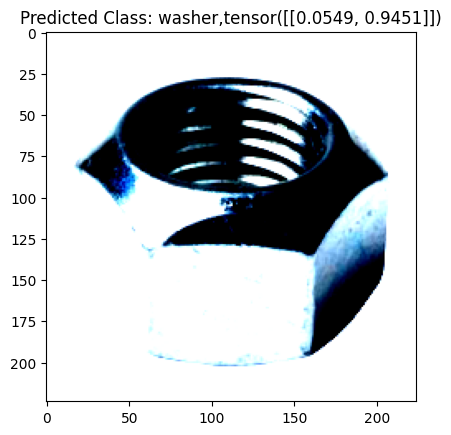

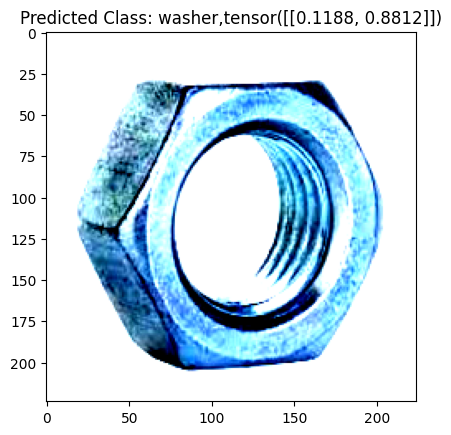

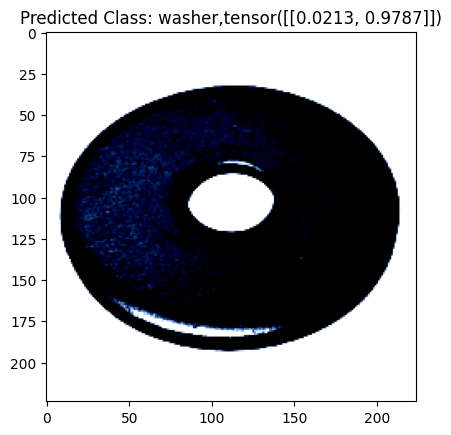

In [46]:
import cv2
from matplotlib import pyplot as plt
testmodel.eval()
for i in os.listdir("/content/finaltest"):
  if i.endswith(".jpg"):
    img=cv2.imread("/content/finaltest/"+i)
    # cv2_imshow(img)
    with torch.no_grad():
      img=Image.open("/content/finaltest/"+i).convert("RGB")
      img=preprocess(img)
      img = img.unsqueeze(0)
      img = img.to(device) # Move input to the same device as the model
      ouptut=testmodel(img)
      prob=torch.softmax(ouptut,dim=1)
      predicted_class = torch.argmax(prob).item()
      img=img.squeeze(0).permute(1,2,0).cpu().numpy()
      plt.imshow(img)
      plt.title(f"Predicted Class: {l[predicted_class]},{prob}")
      plt.show()

In [ ]:
torch.save(model, 'classifier.pth')